In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency
%matplotlib inline

# added dtype in read_csv to avoid dtype warning
# added parse_dates to point out which are dates
df = pd.read_csv('../input/nyc-311-customer-service-requests-analysis/NYC311data.csv', parse_dates=['Created Date','Closed Date','Resolution Action Updated Date'],dtype={'Ferry Direction': str, 'Ferry Terminal Name': str})
df.info()
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300698 entries, 0 to 300697
Data columns (total 53 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   Unique Key                      300698 non-null  int64         
 1   Created Date                    300698 non-null  datetime64[ns]
 2   Closed Date                     298534 non-null  datetime64[ns]
 3   Agency                          300698 non-null  object        
 4   Agency Name                     300698 non-null  object        
 5   Complaint Type                  300698 non-null  object        
 6   Descriptor                      294784 non-null  object        
 7   Location Type                   300567 non-null  object        
 8   Incident Zip                    298083 non-null  float64       
 9   Incident Address                256288 non-null  object        
 10  Street Name                     256288 non-null  object 

In [2]:
def convert_lower(df):
    #convert string columns into lowercase to elimintae duplication
    df = df.applymap(lambda s:s.lower() if type(s) == str else s)
    return df

def drop_empty_columns(df):
    #drop the columns which are completly/almost empty
    na_col_count = df.isna().sum().where(lambda x:x>0).dropna()
    print(na_col_count)
    columns_to_drop = []
    for column in na_col_count.iteritems():
        if(column[1]/8275 >= 0.85):
            columns_to_drop.append(column[0])
    df.drop(columns_to_drop, axis=1, inplace=True)
    return df

def drop_unneccessary_columns(df):
    #drop the unneccesary columns
    cols = ['Descriptor','Location','Address Type','Facility Type','Agency','Agency Name','Community Board','Borough','Park Facility Name','Park Borough','School Region','School Code', 'School Name','School Number','School Phone Number','School Address','School City','School State','School Not Found','School Zip','X Coordinate (State Plane)','Y Coordinate (State Plane)']
    df.drop(cols,axis=1,inplace=True)
    return df

# map, apply, applymap concept

```
df = pd.DataFrame(np.arange(12).reshape(4,3),columns=['a','b','c'])

#df.apply(lambda x:x.sum())  
df.apply(lambda x:x.sum(), axis=0)
df['a+b'] = df.apply(lambda r:r.a+r.b,axis=1)
print(df)

df.applymap(lambda x:'%.2f'% x if x>5 else x)
```

In [3]:
#initial data cleaning  
df = drop_empty_columns(df)
df = drop_unneccessary_columns(df)
df = convert_lower(df)
#afterwards these columns have null values
df.isna().sum().where(lambda x:x>0).dropna()

Closed Date                         2164.0
Descriptor                          5914.0
Location Type                        131.0
Incident Zip                        2615.0
Incident Address                   44410.0
Street Name                        44410.0
Cross Street 1                     49279.0
Cross Street 2                     49779.0
Intersection Street 1             256840.0
Intersection Street 2             257336.0
Address Type                        2815.0
City                                2614.0
Landmark                          300349.0
Facility Type                       2171.0
Due Date                               3.0
Resolution Action Updated Date      2187.0
X Coordinate (State Plane)          3540.0
Y Coordinate (State Plane)          3540.0
School Region                          1.0
School Code                            1.0
School Zip                             1.0
School or Citywide Complaint      300698.0
Vehicle Type                      300698.0
Taxi Compan

Closed Date                       2164.0
Location Type                      131.0
Incident Zip                      2615.0
City                              2614.0
Due Date                             3.0
Resolution Action Updated Date    2187.0
Latitude                          3540.0
Longitude                         3540.0
dtype: float64

In [4]:
#dropping rows where closed and resolution date both are empty
df = df[~(df['Closed Date'].isna() & df['Resolution Action Updated Date'].isna())]
#updating closed date with resolution date where closed date is empty and vice versa
df.loc[df['Closed Date'].isna(),'Closed Date'] = df[df['Closed Date'].isna()]['Resolution Action Updated Date']
df.loc[df['Resolution Action Updated Date'].isna(),'Resolution Action Updated Date'] = df[df['Resolution Action Updated Date'].isna()]['Closed Date']
df.loc[df['Due Date'].isna(),'Due Date'] = df[df['Due Date'].isna()]['Closed Date']

In [5]:
#since now all rows have a completion date(closed/resolution) status of all complaints updated to close
df.loc[df.Status.isin(['open','assigned','draft']),'Status'] = 'closed'

In [6]:
#filling na values based on highest occuring value(mode)
#get mode values
city = df.City.mode()[0]
print('mode: ', df.City.mode())
print('mode[0]: ', city)

zipcode = df.loc[df.City == city,'Incident Zip'].mode()[0]
latitude = df.loc[df['Incident Zip'] == zipcode,'Latitude'].mode()[0]
longitude = df.loc[df['Incident Zip'] == zipcode,'Longitude'].mode()[0]
#fill zipcode,latitude and longitude with modevalues where city is empty and then update city value to mode value
df.loc[df.City.isna(),'Incident Zip'] = zipcode
df.loc[df.City.isna(),'City'] = city
df.loc[(df.City == city) & (df.Latitude.isna()==True),'Latitude'] = latitude
df.loc[(df.City == city) & (df.Longitude.isna()==True),'Longitude'] = longitude

mode:  0    brooklyn
dtype: object
mode[0]:  brooklyn


In [7]:
df.isna().sum().where(lambda x:x>0).dropna()

Location Type    128.0
Incident Zip       4.0
Latitude         773.0
Longitude        773.0
dtype: float64

In [8]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297646 entries, 0 to 300697
Data columns (total 13 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   Unique Key                      297646 non-null  int64         
 1   Created Date                    297646 non-null  datetime64[ns]
 2   Closed Date                     297646 non-null  datetime64[ns]
 3   Complaint Type                  297646 non-null  object        
 4   Location Type                   297646 non-null  object        
 5   Incident Zip                    297646 non-null  float64       
 6   City                            297646 non-null  object        
 7   Status                          297646 non-null  object        
 8   Due Date                        297646 non-null  object        
 9   Resolution Description          297646 non-null  object        
 10  Resolution Action Updated Date  297646 non-null  datetim

In [9]:
df.loc[:,'Request Closing Time(in hours)'] = (df['Closed Date'] - df['Created Date']).dt.total_seconds()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297646 entries, 0 to 300697
Data columns (total 14 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   Unique Key                      297646 non-null  int64         
 1   Created Date                    297646 non-null  datetime64[ns]
 2   Closed Date                     297646 non-null  datetime64[ns]
 3   Complaint Type                  297646 non-null  object        
 4   Location Type                   297646 non-null  object        
 5   Incident Zip                    297646 non-null  float64       
 6   City                            297646 non-null  object        
 7   Status                          297646 non-null  object        
 8   Due Date                        297646 non-null  object        
 9   Resolution Description          297646 non-null  object        
 10  Resolution Action Updated Date  297646 non-null  datetim

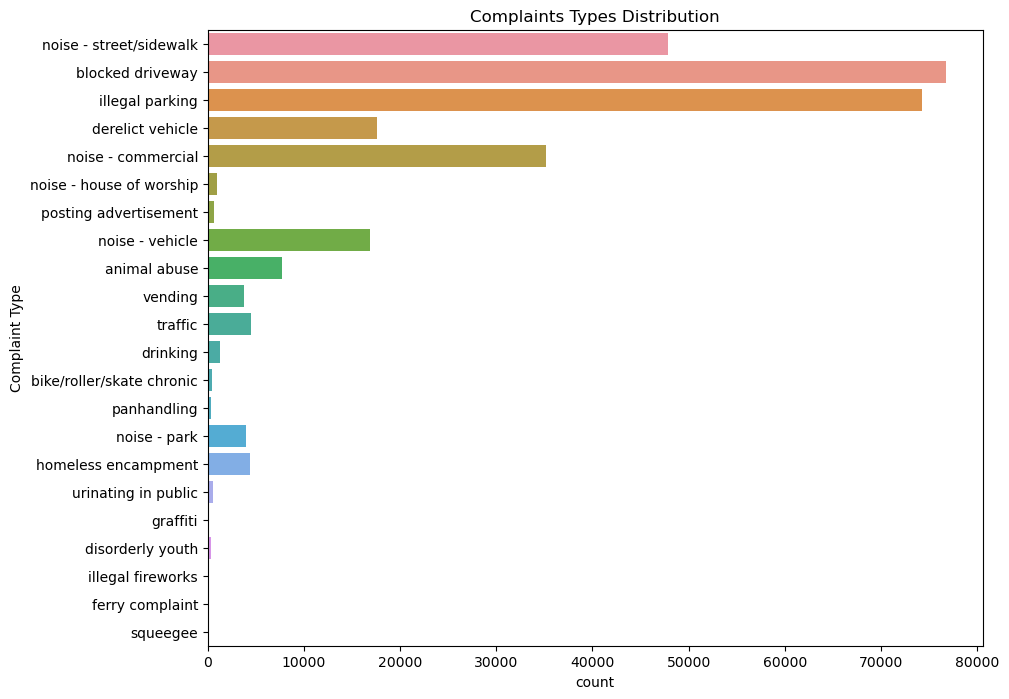

In [11]:
#total complaints based on category

plt.figure(figsize=(10,8)) # create a figure with width 10 inches and height 8 inches
plt.title('Complaints Types Distribution')
sns.countplot(data=df,y='Complaint Type')
plt.show()

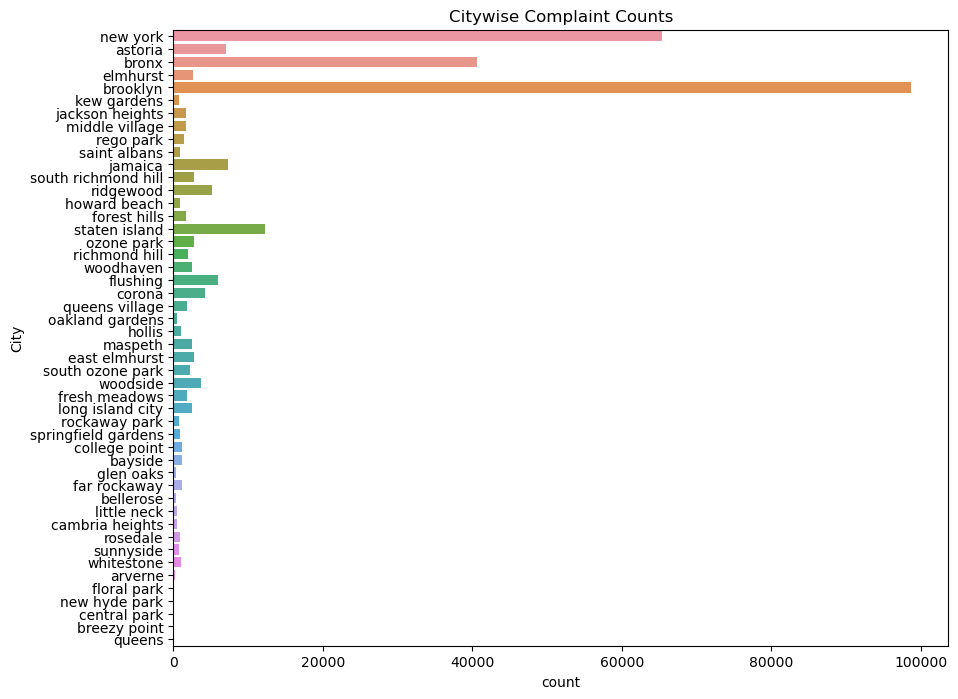

In [12]:
#citywise complaint counts(total)

plt.figure(figsize=(10,8)) # create a figure with width 10 inches and height 8 inches
plt.title('Citywise Complaint Counts')
sns.countplot(data=df,y='City')
plt.show()

In [13]:
top5cities = df['City'].value_counts().head(5).index.to_list()
print(top5cities)
dstop5 = df[df.City.isin(top5cities)]
#print(dstop5)
#citywise complaint counts(typewise)
# crosstab(rows, columns)
df1 = pd.crosstab(dstop5['City'],dstop5['Complaint Type'])
print(df1)

['brooklyn', 'new york', 'bronx', 'staten island', 'jamaica']
Complaint Type  animal abuse  bike/roller/skate chronic  blocked driveway  \
City                                                                        
bronx                   1412                         20             12740   
brooklyn                2394                        113             28189   
jamaica                  229                          2              2816   
new york                1511                        220              2056   
staten island            557                          6              2141   

Complaint Type  derelict vehicle  disorderly youth  drinking  ferry complaint  \
City                                                                            
bronx                       1948                63       187                0   
brooklyn                    5222                72       260                1   
jamaica                      953                 8        34              

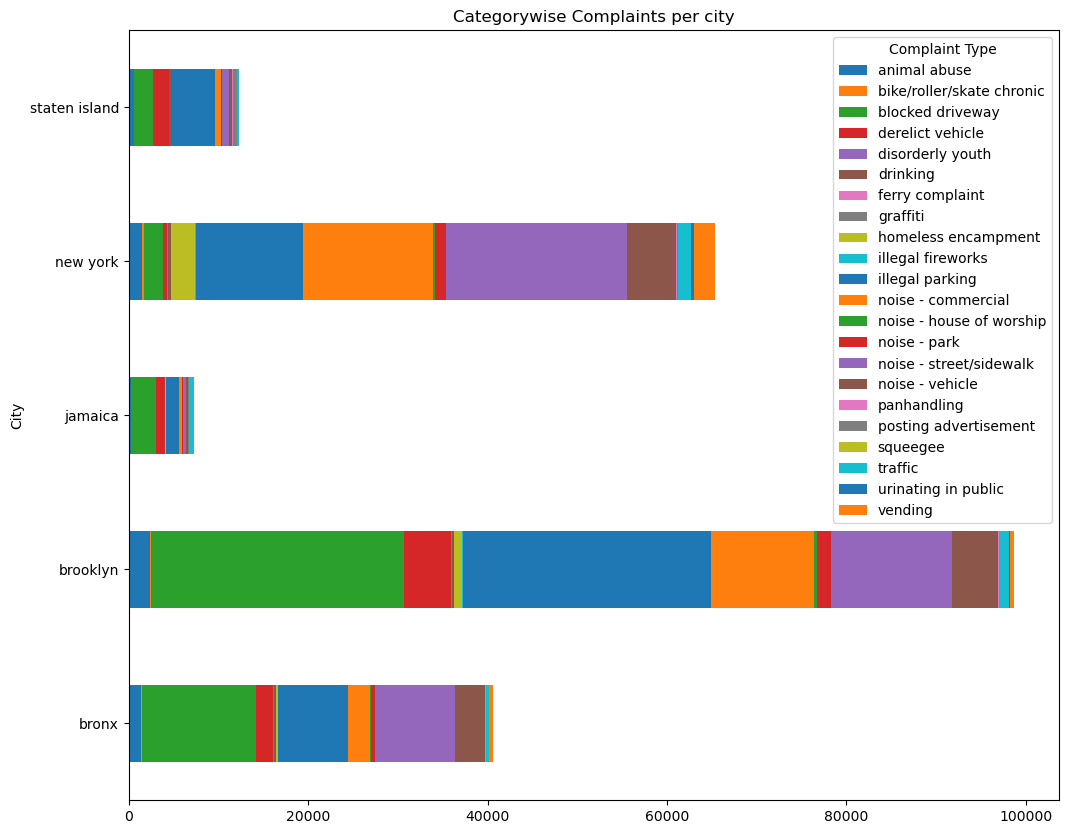

In [14]:
##citywise complaint counts(typewise)
# df1 contains 5 rows of the top5 cities and 22 columns of complaint types
df1.plot(kind='barh',stacked=True,figsize=(12,10))
plt.title('Categorywise Complaints per city')
plt.show()

* Hypothesis testing
* Whether the average response time across complaint types is similar or not (overall)
> When your experiment is trying to draw a comparison or find the difference between one categorical (with more than two categories) and another continuous variable, then you use the ANOVA (Analysis of Variance) test.
> 
* Are the type of complaint or service requested and location related?
> Complaint Type(CAT), Location(CAT) : Chi-Square Test

What is Analysis of Variance test?
An ANOVA test is a way to find out if survey or experiment results are significant. In other words, they help you to figure out if you need to reject the null hypothesis or accept the alternate hypothesis.

Basically, you’re testing groups to see if there’s a difference between them. Examples of when you might want to test different groups:

1. A group of psychiatric patients are trying three different therapies: counseling, medication and biofeedback. You want to see if one therapy is better than the others.
2. A manufacturer has two different processes to make light bulbs. They want to know if one process is better than the other.
3. Students from different colleges take the same exam. You want to see if one college outperforms the other.


In [15]:
#new_ds = ds.dr
complaintTypes = df['Complaint Type'].unique()
print('complaintTypes: ', complaintTypes)
print('length: ', len(complaintTypes))
for i in range(len(complaintTypes)):
    print(complaintTypes[i])
    exec("c{} = df.loc[(df['Complaint Type'] == '{}'),'Request Closing Time(in hours)']".format(i+1,complaintTypes[i]))


complaintTypes:  ['noise - street/sidewalk' 'blocked driveway' 'illegal parking'
 'derelict vehicle' 'noise - commercial' 'noise - house of worship'
 'posting advertisement' 'noise - vehicle' 'animal abuse' 'vending'
 'traffic' 'drinking' 'bike/roller/skate chronic' 'panhandling'
 'noise - park' 'homeless encampment' 'urinating in public' 'graffiti'
 'disorderly youth' 'illegal fireworks' 'ferry complaint' 'squeegee']
length:  22
noise - street/sidewalk
blocked driveway
illegal parking
derelict vehicle
noise - commercial
noise - house of worship
posting advertisement
noise - vehicle
animal abuse
vending
traffic
drinking
bike/roller/skate chronic
panhandling
noise - park
homeless encampment
urinating in public
graffiti
disorderly youth
illegal fireworks
ferry complaint
squeegee


In [16]:
fscore,pvalue = stats.f_oneway(c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16)
print(fscore, pvalue)

541.0488206762245 0.0


> pvalue of 0 (<0.5) mean we reject null hypothesis(i.e complaint type doesn't affect on request closing time).

In [17]:
#Chi square test: Complaint Type(CAT), Location(CAT) this is using test of independence
ctabDF = pd.crosstab(df['Complaint Type'],df['City'])

In [18]:
stat, p, dof, expected = chi2_contingency(ctabDF)
print('Chi-Square Statistic Value: ',stat)
print('p value: ',p)
print('degrees of freedom: ',dof)

Chi-Square Statistic Value:  109359.08964937081
p value:  0.0
degrees of freedom:  987


A Pearson’s chi-square test is a statistical test for categorical data. It is used to determine whether your data are significantly different from what you expected. There are two types of Pearson’s chi-square tests:

1. The chi-square goodness of fit test is used to test whether the frequency distribution of a categorical variable is different from your expectations.
2. The chi-square test of independence is used to test whether two categorical variables are related to each other.

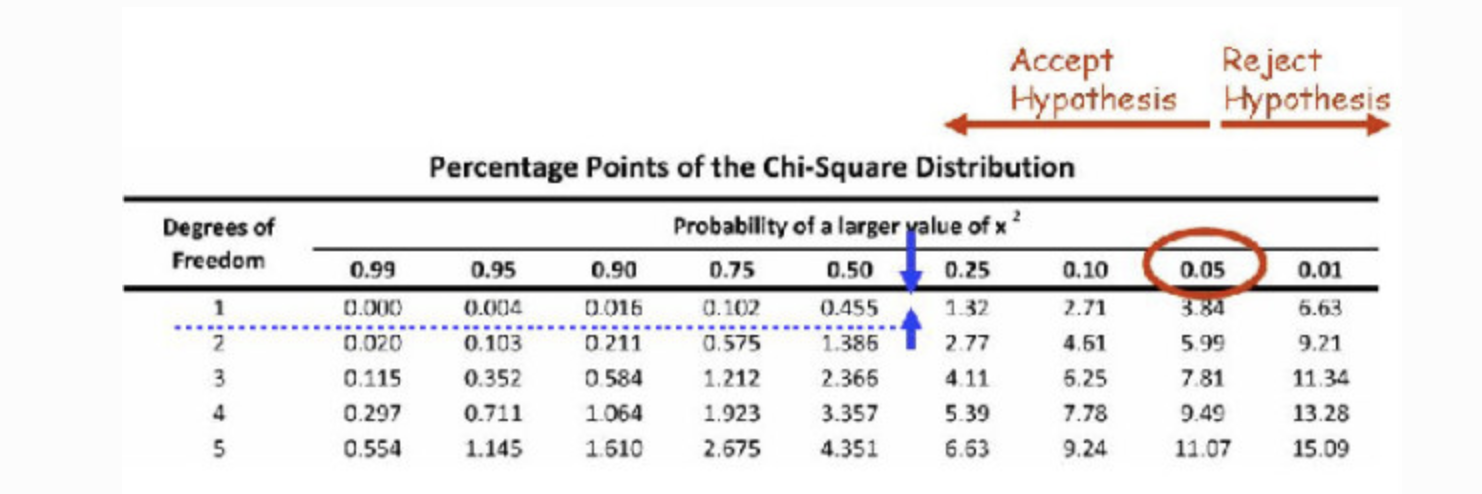

> pvalue of 0 (<0.5) mean we reject null hypothesis(i.e complaint type doesn't affect on request closing time).